--- 1. Data Fetching ---
--- 2. Environment Setup ---
--- 3. Training Agent (150000 steps) ---
Using cpu device


/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_96322/2099210093.py:64: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)


-----------------------------
| time/              |      |
|    fps             | 1174 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 307         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003599547 |
|    clip_fraction        | 0.0191      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | -0.0871     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.0666      |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00148    |
|    std                  | 1.01        |
|    value_loss           | 0.415       |
----------------------------------

/var/folders/04/4l6xjjw976j6gj89kg1qrrf80000gn/T/ipykernel_96322/2099210093.py:64: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)


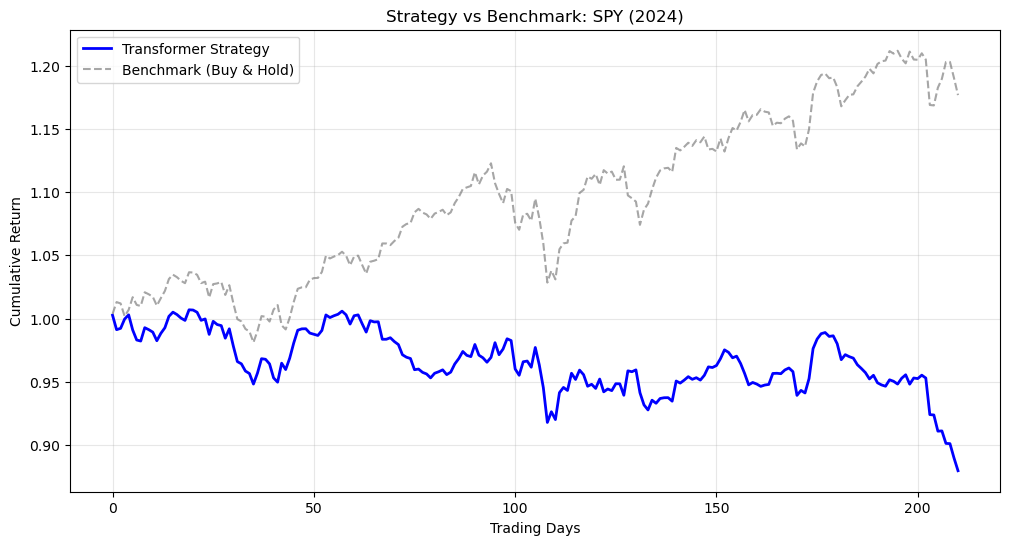

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import matplotlib.pyplot as plt
import sys

# ==========================================
# 1. HYPERPARAMETERS & CONFIGURATION
# ==========================================
CONFIG = {
    # Data Settings
    "TICKERS": ["SPY", "QQQ", "GLD", "^VIX"],
    "TARGET_ASSET": "SPY",
    "START_DATE": "2015-01-01",
    "END_DATE": "2023-12-31",
    "TEST_START_DATE": "2024-01-02",
    
    # Feature Engineering
    "WINDOW_SIZE": 20,
    "TECHNICAL_INDICATORS": True,
    
    # RL Environment Settings
    "INITIAL_BALANCE": 100000,
    "TRADING_FEES": 0.001,  # 0.1% per trade
    
    # Reward Shaping
    # Changed to 'sortino' to fix underperformance in bull markets (penalize only downside)
    "REWARD_METHOD": "sortino", 
    "RISK_AVERSION": 2.0,       # Penalty multiplier for downside moves
    
    # Transformer Architecture
    "D_MODEL": 64,
    "N_HEAD": 4,
    "N_LAYERS": 2,
    "DROPOUT": 0.1,
    
    # PPO Agent Settings
    "LEARNING_RATE": 3e-4,
    "N_STEPS": 2048,
    "BATCH_SIZE": 64,
    "ENTROPY_COEF": 0.05,       # Increased to force exploration (stop agent from freezing)
    "TRAINING_TIMESTEPS": 150000 # Increased further for convergence
}

# ==========================================
# 2. ROBUST DATA PIPELINE
# ==========================================
class DataProcessor:
    def __init__(self, tickers, start_date, end_date):
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        
    def download_data(self):
        print(f"Downloading data for {self.tickers}...")
        try:
            data = yf.download(self.tickers, start=self.start_date, end=self.end_date, progress=False)
            if data.empty:
                return pd.DataFrame()

            # Robust MultiIndex Handling
            if isinstance(data.columns, pd.MultiIndex):
                if 'Close' in data.columns.levels[0]:
                    data = data.xs('Close', level=0, axis=1)
                elif 'Adj Close' in data.columns.levels[0]:
                    data = data.xs('Adj Close', level=0, axis=1)
                elif 'Close' in data.columns.levels[1]:
                    data = data.xs('Close', level=1, axis=1)
            
            if isinstance(data, pd.Series):
                data = data.to_frame()
                
            return data
        except Exception as e:
            print(f"Error during download: {e}")
            return pd.DataFrame()

    def add_technical_indicators(self, df, target_ticker):
        if df.empty or target_ticker not in df.columns:
            return pd.DataFrame()

        df = df.copy()
        
        # Returns
        df['returns'] = df[target_ticker].pct_change()
        
        # RSI
        delta = df[target_ticker].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['rsi'] = 100 - (100 / (1 + rs))
        
        # MACD
        exp1 = df[target_ticker].ewm(span=12, adjust=False).mean()
        exp2 = df[target_ticker].ewm(span=26, adjust=False).mean()
        df['macd'] = exp1 - exp2
        
        # Rolling Volatility
        df['volatility'] = df['returns'].rolling(window=20).std()
        
        # Z-Score (Stationarity)
        window = 20
        rolling_mean = df[target_ticker].rolling(window=window).mean()
        rolling_std = df[target_ticker].rolling(window=window).std()
        df['z_score'] = (df[target_ticker] - rolling_mean) / (rolling_std + 1e-8)
        
        df.dropna(inplace=True)
        return df

    def get_processed_data(self, target_ticker):
        df = self.download_data()
        if df.empty: return pd.DataFrame()
        
        df = self.add_technical_indicators(df, target_ticker)
        if df.empty: return pd.DataFrame()
        
        features = ['returns', 'z_score', 'rsi', 'macd', 'volatility']
        if '^VIX' in df.columns:
            df['vix_norm'] = (df['^VIX'] - df['^VIX'].rolling(50).mean()) / (df['^VIX'].rolling(50).std() + 1e-8)
            df['vix_norm'] = df['vix_norm'].fillna(0)
            features.append('vix_norm')
            
        return df[features].fillna(0)

# ==========================================
# 3. TRADING ENVIRONMENT (WITH SORTINO)
# ==========================================
class TransformerTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, config):
        super(TransformerTradingEnv, self).__init__()
        
        if df is None or df.empty:
            raise ValueError("Empty DataFrame passed to Environment.")
            
        self.df = df
        self.config = config
        self.window_size = config['WINDOW_SIZE']
        self.n_features = df.shape[1]
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.window_size, self.n_features), 
            dtype=np.float32
        )
        
        # State
        self.current_step = self.window_size
        self.balance = config['INITIAL_BALANCE']
        self.portfolio_value = self.balance
        self.history = []
        
        # DSR Memory
        self.A_t = 0
        self.B_t = 0
        self.eta = 0.05

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.window_size
        self.balance = self.config['INITIAL_BALANCE']
        self.portfolio_value = self.balance
        self.A_t = 0
        self.B_t = 0
        self.history = []
        return self._get_observation(), {}

    def _get_observation(self):
        obs = self.df.iloc[self.current_step - self.window_size : self.current_step].values
        return obs.astype(np.float32)

    def _calculate_differential_sharpe(self, returns):
        # Update Stats
        delta_A = returns - self.A_t
        delta_B = (returns ** 2) - self.B_t
        
        prev_A = self.A_t
        prev_B = self.B_t
        
        self.A_t += self.eta * delta_A
        self.B_t += self.eta * delta_B
        
        # DSR Calculation
        denominator = (prev_B - prev_A**2) ** 1.5
        if denominator < 1e-6:
            return 0
            
        dsr = (prev_B * delta_A - 0.5 * prev_A * delta_B) / denominator
        return dsr * 0.1 # Scaling

    def _calculate_sortino(self, returns):
        """
        Sortino Ratio approximation (Doc 2, Section 4.2).
        Penalizes only downside returns.
        r_t = R_t - lambda * (R_t < 0) * R_t^2
        """
        penalty = 0
        if returns < 0:
            penalty = self.config['RISK_AVERSION'] * (returns ** 2)
        
        return returns - penalty

    def step(self, action):
        action = np.clip(action, -1, 1)[0]
        
        if self.current_step >= len(self.df):
            return self._get_observation(), 0, True, False, {}
            
        market_return = self.df.iloc[self.current_step]['returns']
        
        # Costs
        prev_action = self.history[-1]['action'] if len(self.history) > 0 else 0
        turnover = abs(action - prev_action)
        cost = turnover * self.config['TRADING_FEES']
        
        strategy_return = (action * market_return) - cost
        self.portfolio_value *= (1 + strategy_return)
        
        # Reward selection
        if self.config['REWARD_METHOD'] == 'differential_sharpe':
            reward = self._calculate_differential_sharpe(strategy_return)
        elif self.config['REWARD_METHOD'] == 'sortino':
            reward = self._calculate_sortino(strategy_return)
        else:
            reward = strategy_return
            
        self.current_step += 1
        terminated = self.current_step >= len(self.df) - 1
        
        info = {
            'portfolio_value': self.portfolio_value,
            'return': strategy_return,
            'market_return': market_return,
            'action': action
        }
        self.history.append(info)
        
        return self._get_observation(), reward, terminated, False, info

# ==========================================
# 4. TRANSFORMER MODEL
# ==========================================
class TransformerExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 64):
        super().__init__(observation_space, features_dim)
        n_input_features = observation_space.shape[1]
        self.window_size = observation_space.shape[0]
        
        self.embedding = nn.Linear(n_input_features, CONFIG['D_MODEL'])
        self.position_embedding = nn.Parameter(torch.randn(1, self.window_size, CONFIG['D_MODEL']))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=CONFIG['D_MODEL'],
            nhead=CONFIG['N_HEAD'],
            dim_feedforward=128,
            dropout=CONFIG['DROPOUT'],
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=CONFIG['N_LAYERS'])
        
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(CONFIG['D_MODEL'] * self.window_size, features_dim)
        self.activation = nn.ReLU()

    def forward(self, observations):
        x = self.embedding(observations) + self.position_embedding
        x = self.transformer_encoder(x)
        x = self.flatten(x)
        return self.activation(self.linear(x))

# ==========================================
# 5. EXECUTION & ANALYSIS
# ==========================================
def calculate_metrics(returns):
    """Calculates Sharpe Ratio and Max Drawdown."""
    if len(returns) < 2: return 0, 0
    
    # Annualized Sharpe (assuming daily data)
    sharpe = (np.mean(returns) / (np.std(returns) + 1e-9)) * np.sqrt(252)
    
    # Max Drawdown
    cum_returns = (1 + returns).cumprod()
    peak = np.maximum.accumulate(cum_returns)
    drawdown = (cum_returns - peak) / peak
    max_drawdown = drawdown.min()
    
    return sharpe, max_drawdown

def run_strategy():
    print("--- 1. Data Fetching ---")
    data_loader = DataProcessor(CONFIG['TICKERS'], CONFIG['START_DATE'], CONFIG['END_DATE'])
    train_df = data_loader.get_processed_data(CONFIG['TARGET_ASSET'])
    
    if train_df.empty:
        print("CRITICAL: No training data found.")
        return

    print("--- 2. Environment Setup ---")
    try:
        # WRAPPER: VecNormalize is crucial for PPO convergence
        # It normalizes observations and rewards on the fly
        env = DummyVecEnv([lambda: TransformerTradingEnv(train_df, CONFIG)])
        env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)
    except ValueError as e:
        print(f"Env Setup Failed: {e}")
        return
    
    print(f"--- 3. Training Agent ({CONFIG['TRAINING_TIMESTEPS']} steps) ---")
    policy_kwargs = dict(
        features_extractor_class=TransformerExtractor,
        features_extractor_kwargs=dict(features_dim=64),
    )
    
    model = PPO(
        "MlpPolicy", 
        env, 
        policy_kwargs=policy_kwargs, 
        learning_rate=CONFIG['LEARNING_RATE'],
        ent_coef=CONFIG['ENTROPY_COEF'],
        verbose=1
    )
    
    model.learn(total_timesteps=CONFIG['TRAINING_TIMESTEPS'])
    
    # Important: Save the normalization stats if we were deploying.
    # For this script, we just use the trained env stats for testing (implied).

    print("--- 4. Backtesting & Analysis ---")
    test_loader = DataProcessor(CONFIG['TICKERS'], CONFIG['TEST_START_DATE'], "2025-01-01")
    test_df = test_loader.get_processed_data(CONFIG['TARGET_ASSET'])
    
    if test_df.empty or len(test_df) <= CONFIG['WINDOW_SIZE']:
        print("Insufficient test data.")
        return

    # For testing, we generally do NOT normalize rewards (we want real $), 
    # but we MUST normalize observations using the training statistics.
    # To simulate this without saving/loading files:
    # We create a new env, wrap it, but disable training/reward updates.
    test_env = DummyVecEnv([lambda: TransformerTradingEnv(test_df, CONFIG)])
    # We transfer the moving averages from training env to test env
    test_env = VecNormalize(test_env, norm_obs=True, norm_reward=False, clip_obs=10.)
    test_env.obs_rms = env.obs_rms # COPY TRAINING STATS TO TEST ENV
    test_env.training = False # DO NOT UPDATE STATS DURING TEST

    obs = test_env.reset()
    done = False
    
    strategy_history = []
    
    while True: # Vectorized envs don't use 'done' the same way in loops
        action, _ = model.predict(obs, deterministic=True)
        
        # FIXED: VecEnv (SB3) always returns 4 values: obs, reward, done, info
        # even if the underlying Gymnasium env returns 5.
        obs, reward, done_array, info_array = test_env.step(action)
        
        # Extract info from vectorized environment (it returns a list)
        info = info_array[0]
        strategy_history.append(info)
        
        if done_array[0]:
            break
        
    # --- Performance Analysis ---
    results_df = pd.DataFrame(strategy_history)
    
    # 1. Strategy Metrics
    strategy_returns = results_df['return']
    cum_strategy = (1 + strategy_returns).cumprod()
    strat_sharpe, strat_mdd = calculate_metrics(strategy_returns)
    strat_total_return = (results_df['portfolio_value'].iloc[-1] / CONFIG['INITIAL_BALANCE']) - 1
    
    # 2. Benchmark Metrics (Buy & Hold)
    benchmark_returns = results_df['market_return']
    cum_benchmark = (1 + benchmark_returns).cumprod()
    bench_sharpe, bench_mdd = calculate_metrics(benchmark_returns)
    bench_total_return = cum_benchmark.iloc[-1] - 1
    
    print("\n" + "="*40)
    print(f"FINAL PERFORMANCE REPORT ({CONFIG['TARGET_ASSET']})")
    print("="*40)
    print(f"{'Metric':<20} | {'Strategy':<12} | {'Benchmark':<12}")
    print("-" * 50)
    print(f"{'Total Return':<20} | {strat_total_return:>11.2%} | {bench_total_return:>11.2%}")
    print(f"{'Sharpe Ratio':<20} | {strat_sharpe:>11.2f} | {bench_sharpe:>11.2f}")
    print(f"{'Max Drawdown':<20} | {strat_mdd:>11.2%} | {bench_mdd:>11.2%}")
    print("-" * 50)
    print(f"Initial Balance: ${CONFIG['INITIAL_BALANCE']:,.2f}")
    print(f"Final Balance:   ${results_df['portfolio_value'].iloc[-1]:,.2f}")
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(cum_strategy, label='Transformer Strategy', color='blue', linewidth=2)
    plt.plot(cum_benchmark, label='Benchmark (Buy & Hold)', color='gray', linestyle='--', alpha=0.7)
    plt.title(f"Strategy vs Benchmark: {CONFIG['TARGET_ASSET']} (2024)")
    plt.ylabel('Cumulative Return')
    plt.xlabel('Trading Days')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    torch.set_num_threads(4)
    run_strategy()